## Part 1

The goal of this part is to explore some of the main [scikit-learn](http://scikit-learn.org/stable/index.html) tools on a single practical task: analysing a collection of text documents (newsgroups posts) on twenty different topics.

In this section we will see how to:

1. load the file contents and the categories
2. extract feature vectors suitable for machine learning
3. train a model to perform text classification
4. evaluate the performance of the trained model


### Loading the 20 newsgroups dataset
The 20 newsgroups dataset comprises around 20,000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). 

In the following we will use the built-in dataset loader for 20 newsgroups from scikit-learn.

The **sklearn.datasets.fetch_20newsgroups** function is a data fetching / caching functions that downloads the data archive from the original 20 newsgroups website, extracts the archive contents in a local folder and calls the **sklearn.datasets.load_files** on either the training or testing set folder, or both of them. Here, we are loading only 4 categories.

In [0]:
cats = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space'] #select only 4 categories for fast running times

from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, remove=('headers', 'footers', 'quotes'))


We can now list the 4 categories as follows:

In [660]:

print(newsgroups_train.target_names)

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


The real data lies in the **filenames** and **target** attributes. The target attribute is the integer index of the category:

In [661]:
print(newsgroups_train.filenames[0]) #print the name of the first file
print(newsgroups_train.data[0]) #print the text of the first example

/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38816
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


### Converting text to vectors
In order to feed machine learing models with the text data, one first need to turn the text into vectors of numerical values suitable for statistical analysis. This can be achieved with the utilities of the **sklearn.feature_extraction.text** as demonstrated in the following example.




In [662]:
from sklearn.feature_extraction.text import CountVectorizer #tokenizer
vectorizer = CountVectorizer(stop_words='english') #remove english stop words
vectors = vectorizer.fit_transform(newsgroups_train.data)
print (vectors.shape) #print the size

(2034, 26576)


### Training a machine learining model and evaluate its performance
 Let’s use a multinomial Naive Bayes classifier as discussed in the class.

In [663]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(vectors, newsgroups_train.target)



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Then let's print the F1 score on the test data.

In [664]:
from sklearn import metrics

newsgroups_test = fetch_20newsgroups(subset='test', categories=cats, remove=('headers', 'footers', 'quotes'))  #test data
vectors_test = vectorizer.transform(newsgroups_test.data)  #generate vectors from test data (using the same vectorizer)
pred = clf.predict(vectors_test) #predict categories for the test data using the above trained classifier

print("macro F1:",metrics.f1_score(newsgroups_test.target, pred, average='macro'))
print("micro F1:",metrics.f1_score(newsgroups_test.target, pred, average='micro'))
print("\n",metrics.classification_report(newsgroups_test.target, pred, target_names=newsgroups_test.target_names))
cm = metrics.confusion_matrix(newsgroups_test.target, pred)
print("Confusion Matrix:\n",cm)

macro F1: 0.7564987834068887
micro F1: 0.7804878048780488

                     precision    recall  f1-score   support

       alt.atheism       0.65      0.71      0.68       319
     comp.graphics       0.91      0.90      0.91       389
         sci.space       0.82      0.87      0.85       394
talk.religion.misc       0.66      0.53      0.59       251

          accuracy                           0.78      1353
         macro avg       0.76      0.76      0.76      1353
      weighted avg       0.78      0.78      0.78      1353

Confusion Matrix:
 [[226   7  28  58]
 [ 11 352  23   3]
 [ 24  19 344   7]
 [ 87   8  22 134]]


Let’s take a look at what the most informative features are:

In [665]:
import numpy as np
def show_top10(classifier, vectorizer, categories):
  feature_names = np.asarray(vectorizer.get_feature_names())
  for i, category in enumerate(categories):
    top10 = np.argsort(classifier.coef_[i])[-10:]
    print("%s: %s" % (category, " ".join(feature_names[top10])))

show_top10(clf, vectorizer, newsgroups_train.target_names)

alt.atheism: like believe say atheism does just think don people god
comp.graphics: software images files data use file jpeg edu graphics image
sci.space: just shuttle time orbit data like earth launch nasa space
talk.religion.misc: know say christian think just bible don jesus people god


Instead of train-test setup, you can also perform cross-validation (CV). Following code shows CV results using the train set (although you could do this with the complete dataset).

In [666]:
from sklearn.model_selection  import cross_val_score
cv_scores = cross_val_score(clf, vectors, newsgroups_train.target , cv=10, scoring="f1_macro" )
print("Avg. macro F1:", np.mean(cv_scores))

Avg. macro F1: 0.8128198197572788


## Part 2

Ths goal of this part is to write your own code to train a model to classify the given test dataset using part 1 as inspiriation.

First, upload the given dataset ("diseases-train.csv") using the following cell. It contains 900 scientific artciles (identified by their PubMed IDs) and their labels. This is a multi-class problem.



In [667]:
from google.colab import files
uploaded = files.upload()

Saving diseases-train.csv to diseases-train (3).csv


Then load the CSV file using pandas as below. 

In [0]:
import pandas as pd
df_train = pd.read_csv("diseases-train.csv")

Then you can iterate over the lines as follows. Each line has the format: pmid, category.

In [669]:
for index, row in df_train.iterrows():    
    pmid = row[0]
    print(pmid)
    break

30141778


Then you can get the other information (i.e. title, abstract etc) associated with each of these articles using the [biopython](https://biopython.org/) library. First insatll the library as below.

In [670]:
!pip install biopython

You can fetch the information for an article with the **eftech** function as below. Find more information [here](http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec:efetch). 

(Note: You can search for pubmed articles using keywords using [esearch](http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc123). This may be useful for your projects.)

In [671]:
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"  # Always tell NCBI who you are
handle = Entrez.efetch(db="pubmed", id=pmid, rettype="medline", retmode="text")
print(handle.read())


PMID- 30141778
OWN - NLM
STAT- MEDLINE
DCOM- 20180904
LR  - 20180904
IS  - 1524-4725 (Electronic)
IS  - 1076-0512 (Linking)
VI  - 44
IP  - 9
DP  - 2018 Sep
TI  - Inside "Outside" Job: Unexpected Geometric Skin Ulcerations Overlying Orthopedic 
      Hardware After Multimodal Laser Scar Revision.
PG  - 1231-1233
LID - 10.1097/DSS.0000000000001433 [doi]
FAU - Borok, Jenna
AU  - Borok J
AD  - Division of Pediatric and Adolescent Dermatology, Rady Children's Hospital, San
      Diego, California Department of Dermatology, University of California, Irvine
      Irvine, California Department of Medicine, University of California, San Diego,
      California DermOne, LLC, West Conshohocken, Pennsylvania.
FAU - Ferris, Katherine
AU  - Ferris K
FAU - Vaux, Keith
AU  - Vaux K
FAU - Krakowski, Andrew C
AU  - Krakowski AC
LA  - eng
PT  - Case Reports
PT  - Journal Article
PL  - United States
TA  - Dermatol Surg
JT  - Dermatologic surgery : official publication for American Society for Dermatologi

The decription of the medline format is [here](https://www.nlm.nih.gov/bsd/disted/pubmedtutorial/030_080.html). You can parse this *handle* using the **Medline.parse** function. More informaton is [here](https://biopython.org/DIST/docs/api/Bio.Medline-module.html).

Once you grab enough information about each article from pubmed, your task is to train a model uisng the given data and make predictions for the articles in test data ("diseases-test-without-labels.csv"). In order to find the best parameter values for your models, you will split the given data into train-1 and train-2. Then you will use train-1 to train your models and train-2 to test your models (typically, train-2 is called the dev set or validation set). This way, you are able to find the best model for making final predictions. 

You can add one more code/text blocks for answering the follwoing.



In [672]:
# block for needed imports
### Basically, if the imports above are not considered to be part of y
from Bio import Medline
from Bio import Entrez
import matplotlib.pyplot as plt 
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus.reader.wordnet import NOUN
from nltk.stem.api import StemmerI
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer 
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
tokens = RegexpTokenizer('\w+')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stemmer = LancasterStemmer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def print_table(distributions, prob, objects, size, name):
  header = None
  incr1 = None
  sep = "-"
  for i in range(len(objects)):  # ALL parameters are same length, iterate through range to access all
    if i is 0:  # setup header & spacers
      label = "Class Label" + ' '*12 + "Frequency" +' '*12 + "Probability"
      incr1 = len("Class Label")
      header = '_'*len(label)
      print(' '*(len(header)- len(name))+name)
      print(header, '\n'+label,'\n'+label, '\n'+header,'\n')

    # gets data for each iteration
    label = objects[i] 
    dif = (incr1+12)-len(label)+len(str(distributions[i]))  # calculate difference by header
    label += sep*dif +str(distributions[i])
    dif = len(header)-len(label)-len(str(prob[i])+'%') # calculate difference by header and current label string
    label+=sep*dif+prob[i]+'%'
    print(label)
  print(header , '\n'+header)
  if (name is not 'df_train'):
    print('\nPercent of df_train '+ '-'*(len(header)-len('Percent of df_train %')-len(str(size/900*100)))+' '+str(size/900*100)+'%')
  print("Total data: " + '-'*(len(header)-len("Total data:  ")- len(str(size))) + ' '+ str(size), '\n'+header,'\n'*2)
    
    

In [0]:
def make_chart(data_set, name):
  dist_dict = {}  # key:val = class label : occurance
  objects = ()  # contains labels
  distributions = []  # contains label distributions
  prob = []
  for label in data_set['category']:
    if label in dist_dict.keys():
      dist_dict[label] += 1  # add one to occurences
    else:
      dist_dict[label] = 1  # one occurence
  total_data = data_set.shape[0]  # number of data points
  
  for key,value in dist_dict.items():  # find probabilities and get labels
    prob.append(format((value/total_data*100), '.4f'))
    objects += (key,)
    distributions.append(value)
    y_pos = np.arange(len(objects))
    
  # create more defined bar chart by changing y limit
  low = min(distributions)
  high = max(distributions)
  plt.ylim((low-(high-low)),high)  # display distibution more clearly
  test = plt.bar(y_pos, distributions, align='center', alpha=0.5)
  plt.xticks(y_pos, objects)
  plt.ylabel('Occurences')
  plt.title(name + ' Distibutions')
  plt.show()
  print()
  print_table(distributions,prob,objects, len(data_set), name)  # prints table of class lable data
    

In [0]:

    
def stem_lemm(token, stop, action):
  ws = ''
  for word in token:  # iterate through each word from token
    if word not in stop:  # remove stop words
      if action is 'lem':
        stem_word = stemmer.stem(word)
        ws+=stem_word + ' '  # concatenate to a string of all words

      else:
        lemma_word = lemmatizer.lemmatize(word)
        ws+=lemma_word + ' '  # concatenate to a string of all words
  return ws


In [0]:
def get_tokens(in_data, status):
  if not status is 'labels':
    return get_tokens_test(in_data)
  else:
    return get_tokens_train(in_data)
  

In [0]:
def get_tokens_test(in_data):
  stop_words = set(stopwords.words('english'))   # stop words to get  rid of
  data_l = []  # append report strings 
  for pmid in in_data['pmid']: # iterate through each example
    Entrez.email = "Jrkeeling23@gmail.com"
    handle = Entrez.efetch(db="pubmed", id=pmid, rettype="medline", retmode="text")
    parse = Medline.parse(handle)
    for record in parse:  # iterate through report data
      if 'TI' in record.keys():  # check if TI is in data
        data_token = tokens.tokenize(record['TI'])
        data_l.append(stem_lemm(data_token, stop_words, 'stem'))  # append stemmed and lemmatized data
  return data_l

In [0]:
def get_tokens_train(in_data):
  stop_words = set(stopwords.words('english'))   # stop words to get  rid of
  data_l = []  # append report strings 
  labels = []  # holds labels in parallel to data_l strings
  
  for i, row in in_data.iterrows(): # iterate through each example
    Entrez.email = "Jrkeeling23@gmail.com"
    handle = Entrez.efetch(db="pubmed", id=row['pmid'], rettype="medline", retmode="text")
    parse = Medline.parse(handle)
    for record in parse:  # iterate through report data
      if 'TI' in record.keys():  # check if TI is in data
        labels.append(row['category'])
        data_token = tokens.tokenize(record['TI'])
        data_l.append(stem_lemm(data_token, stop_words, 'stem'))  # append stemmed and lemmatized data
  return data_l, labels

In [0]:
def feature_model():
  return CountVectorizer(stop_words='english', max_df=.9) #remove english stop words
  
def vectorize(in_data1, in_data2, fm):
  vector = fm.fit_transform(in_data1)
  vectors_test = fm.transform(in_data2)  #generate vectors from test data (using the same vectorizer)
  return vector, vectors_test


In [0]:
def perform_NB(in_labels1, in_labels2, vector, vectors_test):
  clf = MultinomialNB(alpha =1, fit_prior=False)
  clf.fit(vector, in_labels1)  # associate labels with vector
  pred = clf.predict(vectors_test) #predict categories for the test data using the above trained classifier
  # print stats
  if in_labels2 is not '':
    print("macro F1:",metrics.f1_score(in_labels2, pred, average='macro'))
    print("micro F1:",metrics.f1_score(in_labels2, pred, average='micro'))
    print("\n",metrics.classification_report(in_labels2, pred))
    cm = metrics.confusion_matrix(in_labels2, pred)
    print("Confusion Matrix:\n",cm)
    return metrics.classification_report(in_labels2, pred, output_dict=True)
  else:
    return pred
  
  

In [0]:
def knn(in_data1, in_data2, in_labels1, in_labels2):
  vectorizer = CountVectorizer(stop_words='english', max_df=.3) #remove english stop words
  vector = vectorizer.fit_transform(in_data1)
  clf.fit(vector, in_labels1)
  knn = KNeighborsClassifier(n_neighbors=3, algorithm='brute', weights="distance")
  knn.fit(vector, in_labels1)
  vectors_test = vectorizer.transform(in_data2)  #generate vectors from test data (using the same vectorizer)
  pred = knn.predict(vectors_test)

  return metrics.classification_report(in_labels2, pred, output_dict=True)

In [0]:
def make_f1_chart(nb, kn):
  bar_width=0.35  
  knn_score = []  # keep scores of nb
  nb_score = []  # keep scores of knn
  lab = list(nb.keys())[:4]  # get categories
  groups = len(lab) # size of index

  for l in lab:
    knn_score.append((kn[l]['f1-score']))  # assign scores
    nb_score.append((nb[l]['f1-score']))
    

  bar1 = plt.bar(np.arange(groups),nb_score,bar_width, color='b',label='NB')
  bar1 = plt.bar(np.arange(groups)+bar_width,knn_score,bar_width, color='r',label='KNN')

  plt.xlabel('Model')
  plt.ylabel('F1 Scores')
  plt.title('Scores by Model')
  plt.xticks(np.arange(groups)+bar_width,tuple(lab))
  plt.legend()
  plt.tight_layout()
  plt.show()

In [0]:
def make_f1_chart_nb(nb):
  bar_width=0.35  
  knn_score = []  # keep scores of nb
  nb_score = []  # keep scores of knn
  lab = list(nb.keys())[:4]  # get categories
  groups = len(lab) # size of index

  for l in lab:
    nb_score.append((nb[l]['f1-score']))
    

  bar1 = plt.bar(np.arange(groups),nb_score,bar_width, color='b',label='NB')

  plt.xlabel('Model')
  plt.ylabel('F1 Scores')
  plt.title('Scores by Model')
  plt.xticks(np.arange(groups)+bar_width,tuple(lab))
  plt.legend()
  plt.tight_layout()
  plt.show()

1. Details about datasets: What is the label distribution in the full dataset? What are the sizes of train-1 and train-2 datasets you used (and their individual label distriutions)? Also, show the distribution(s) visually.

(Note: you can create bar plots or pie charts using the following:
[matplotlib.pyplot.bar](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.bar.html), 
[matplotlib.pyplot.pie](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pie.html)) 


The graphs portray the distibution (221, 225, 227, 227 to Skin,Eye, Brain, Heart diseases respectively). The distributuions are going to be random for each train1 and train2 because the data is randomly  split. 
The sizes of train1 and train2 are also in the table  under the graphs. (But they are train1 80% and train2 20%)

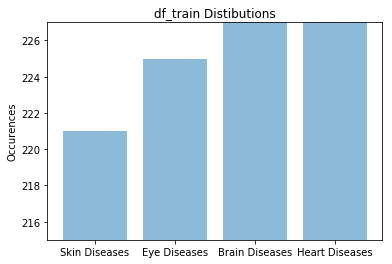


                                               df_train
_______________________________________________________ 
Class Label            Frequency            Probability 
Class Label            Frequency            Probability 
_______________________________________________________ 

Skin Diseases-------------221------------------24.5556%
Eye Diseases--------------225------------------25.0000%
Brain Diseases------------227------------------25.2222%
Heart Diseases------------227------------------25.2222%
_______________________________________________________ 
_______________________________________________________
Total data: --------------------------------------- 900 
_______________________________________________________ 




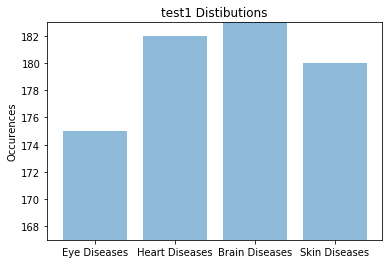


                                                  test1
_______________________________________________________ 
Class Label            Frequency            Probability 
Class Label            Frequency            Probability 
_______________________________________________________ 

Eye Diseases--------------175------------------24.3056%
Heart Diseases------------182------------------25.2778%
Brain Diseases------------183------------------25.4167%
Skin Diseases-------------180------------------25.0000%
_______________________________________________________ 
_______________________________________________________

Percent of df_train ------------------------------ 80.0%
Total data: --------------------------------------- 720 
_______________________________________________________ 




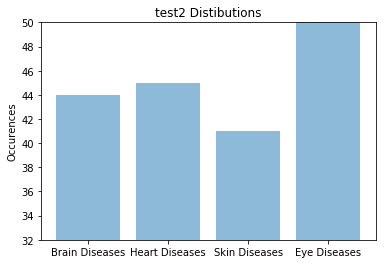


                                                  test2
_______________________________________________________ 
Class Label            Frequency            Probability 
Class Label            Frequency            Probability 
_______________________________________________________ 

Brain Diseases-----------44--------------------24.4444%
Heart Diseases-----------45--------------------25.0000%
Skin Diseases------------41--------------------22.7778%
Eye Diseases-------------50--------------------27.7778%
_______________________________________________________ 
_______________________________________________________

Percent of df_train ------------------------------ 20.0%
Total data: --------------------------------------- 180 
_______________________________________________________ 




In [684]:
train1, train2 = np.split(df_train.sample(frac=1), [int(.8 * len(df_train))])

make_chart(df_train, 'df_train')
make_chart(train1, 'test1')
make_chart(train2, 'test2')

2. Data preprocessing:
How did you preprocess you data? You can do stemming/lemmatization using [NLTK](https://www.nltk.org/) library:
[stemming](https://www.nltk.org/api/nltk.stem.html), 
[lemmatization](https://www.nltk.org/_modules/nltk/stem/wordnet.html). Make sure to apply the same pre-processing to both train-1 and train-2.


For my pre processing, I tried both lemmatization and stemming. I also added in a set of stop words which if the report contains them, they are eliminated them from the report. 
Also, after analyzing how the Pubmed documents are structured, I based the premise of what data to take from the 'TI' section. 
This is an approach I took after using all the data; which had a worse score typically.

In [0]:
proccessed_train1, t1_labels = get_tokens(train1, 'labels')
proccessed_train2, t2_labels = get_tokens(train2, 'labels')

3. Features used:
What feature model was used? Chekout all the options for [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Also, instead of the Bag-of-words (CountVectorizer) model you can optionally use [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). You can read more about both these approches [here](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). Regarless of the Vectorizer used, list all paramer values you used.


The feature model I use is CounterVectotizer. This contains, as parameters, a stop words and a max_df. The max_df ignores words that appear in a specified percentage of the data.


In [0]:
fm = feature_model()  # get instance of CounterVectorizer
vector, vector_test = vectorize(proccessed_train1, proccessed_train2, fm)  # get vectors



4. NB Model performance:
Report the performance values using Naive Bayes here. What is represented by *alpha* and *fit_prior* parameters? What value pair for *alpha* (try 0.0 or 1.0) and *fit_prior* (try True or False) parameters gives you the best overall performance in terms of macro-avreaged F1 (train using train-1 and test using train-2). For the best performing model, show confusion matrix. Show individual F1 values for each category in a bar chart. What are the categories that are easiest/ hardest to predict?




I have kept these values below.
Using alpha=1 is better in terms of macro average.
Using fit_prior False works better regarding macro average
The hardest to predict seem to be Skin diseases and Brain Diseases, while the other two are most easy. 

macro F1: 0.6567348146926649
micro F1: 0.6666666666666666

                 precision    recall  f1-score   support

Brain Diseases       0.69      0.70      0.70        44
  Eye Diseases       0.74      0.62      0.67        50
Heart Diseases       0.64      0.87      0.74        45
 Skin Diseases       0.59      0.46      0.52        41

      accuracy                           0.67       180
     macro avg       0.67      0.66      0.66       180
  weighted avg       0.67      0.67      0.66       180

Confusion Matrix:
 [[31  3  5  5]
 [ 6 31  7  6]
 [ 4  0 39  2]
 [ 4  8 10 19]]


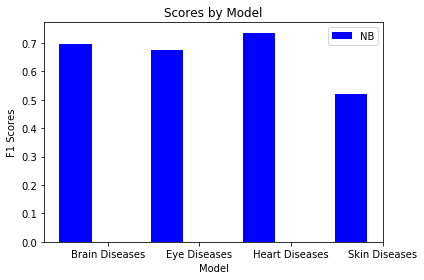

In [687]:
nb_data = perform_NB(t1_labels, t2_labels, vector, vector_test)  # get NB stats
make_f1_chart_nb(nb_data)

5. Other Model performance:
Comapre NB performance to at least one other model mentioned in the class (e.g. KNN). Which model did you pick? List all parameter values you selected. Show the individual F1 values for each category for the two models side-by-side in a bar chart.



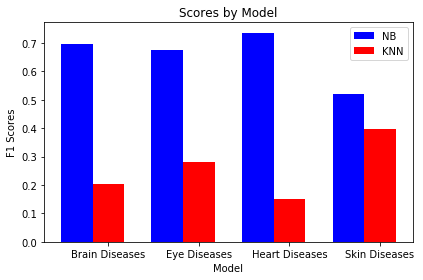

In [688]:
knn_data = knn(proccessed_train1, proccessed_train2, t1_labels, t2_labels)
make_f1_chart(nb_data, knn_data)

I used KNN. For the parameters I used the brute force algorithm and weighted the data based off of distance from the query point. 
I also changed the vectorizer for the data. By using the max_df, I eliminated words that only appeared in 70% of the data. 




6. Predict the categories for articles in the given test data set ("diseases-test-without-labels.csv"). Save the predictions into "diseases-test-preds.csv" (it should have the exact same format as the "diseases-train.csv" file) and upload along with the completed ipynb file. We will use your generated "diseases-test-preds.csv" file for evaluting the final perforamnce of your code (using macro-averaged F1). 

The three best performing submissions on test data will get **bonus points** (5% of the assignment grade for the 1st place, 3% for 2nd, and 2% for 3rd). The winner will be annouced in the class afther final evalution.

In [691]:
train_upload = files.upload()
  

Saving diseases-test-without-labels.csv to diseases-test-without-labels (1).csv


In [0]:
df_test = pd.read_csv("diseases-test-without-labels.csv")
train, train_l =  get_tokens(df_train, 'labels')

In [0]:

test = get_tokens(df_test, 'no_labels')
fm = feature_model()
v1, v2 = vectorize(train,test, fm)
predicted = perform_NB(train_l,'',v1, v2)
pred = {}
pred['pmid'] = predicted
pred = pd.DataFrame(pred)
pred.to_csv("diseases-test-preds.csv")
  